# ** Code to download and plot reservoir storage-level data from Chennai ** 
## ** Importing libraries **

In [2]:
import mechanicalsoup
import pandas as pd
import matplotlib.pyplot as plt
import glob

In the following code, we are going to try and extract information about
reservoir levels in and around Chennai, India. The website uses a form, the input for which is the date in the format DD/MM/YYYY - 09/03/2015. You need the 0 when you have a single digit day or month. 

We will use ** mechanosoup ** to extract this information. The website is exceedingly slow - so, it may not be the fleetest of codes. More importantly, expect not-so-infrequent ConnectionResetError

The following code works - when the website allows it to:

!!!!!!!!! ** Code ** !!!!!!!!!
```Python

url = 'http://123.63.203.150/reserve.asp'
   
b = mechanicalsoup.StatefulBrowser()

b.open(url)

b.select_form('form[action="reserve.asp"]')

b["ldate"] = "19/07/2020"

b["b1"] = "Submit"

r = b.submit_selected()

```
!!!!!! ** End of Code ** !!!!!!

** Important not to put b.open(url) in a loop. That works too but 
increases the time for execution as well as the chances of connection
errors **.

In [2]:
'''
This cell of the code needs to be executed only once. I think the 
b.open(url) can take quite long - so, better not to put it in a loop.
Moreover, it is not necessary!
'''

url = 'http://123.63.203.150/reserve.asp'
   
b = mechanicalsoup.StatefulBrowser()

b.open(url)

'''
b.select_form('form[action="reserve.asp"]')

b["ldate"] = "19/07/2020"
b["b1"] = "Submit"

r = b.submit_selected()
'''

'\nb.select_form(\'form[action="reserve.asp"]\')\n\nb["ldate"] = "19/07/2020"\nb["b1"] = "Submit"\n\nr = b.submit_selected()\n'

** How do you select the form from a web site? **

If you read through the website ['http://123.63.203.150/reserve.asp'], you'd see that there is a form that contains the string
"action="reserve.asp"]". That is what we use to select the form - 
important in case there are more than 1 forms on the page.
```Python
b.select_form('form[action="reserve.asp"]')
```

** How do you get details of the form of interest? **

Run the following line to get that information

```python
b.get_current_form().print_summary()
```

** Creating a date range for downloading data **

In [3]:
'''
Change these dates according to your needs
'''

dates_needed = pd.date_range(start="21-Aug-2004",
                             end="31-Dec-2010").strftime("%d/%m/%Y")

# Python seems to have a function for every need of yours! I thought of
# converting the date by a method I have not yet hit upon. But there is
# strftime that does it for you. How did I find the particular format?
# %B gives the entire month name - January, February, etc
# Then, on a whim, I tried %b. Worked out.

** Function to save data into a csv file **

In [4]:
def save_pdDf_toCSV(pdDF, CSVfilename):
    '''
    A function to save a pandas dataframe to a csv file, usually to be 
    used in a for loop. At the end of each cycle of the loop, a dataframe
    is appended to a filename CSVfilename.
    '''
    try:
        open(CSVfilename)
    except FileNotFoundError:
        open(CSVfilename, 'w')
        f = open(CSVfilename, 'w')
        pdDF.to_csv(f, header=pdDF.columns)
    
    with open(CSVfilename, 'a') as f:
        pdDF.to_csv(f, header=False)

** Here is the key part of the code. **

What is nice is the discarding of those dates when data is not available,
which the Chennai website lets us know by returning a page with the string 'Level is not available for the date '

In [163]:
for date in dates_needed:
    b.select_form('form[action="reserve.asp"]')
    b["ldate"] = date
    b["b1"] = "Submit"
    r = b.submit_selected()
    
    if ('Level is not available for the date ' + date not in r.text):
        resdetails = pd.read_html(r.text, skiprows=0, 
                                  header = 0, index_col = 'RESERVOIR')[0]
    
        poondiappend = pd.DataFrame(resdetails.loc['POONDI',:].append(pd.Series({'date':date}))).T
    
        cholavaramappend = pd.DataFrame(resdetails.loc['CHOLAVARAM',:].append(pd.Series({'date':date}))).T
    
        redhillsappend = pd.DataFrame(resdetails.loc['REDHILLS',:].append(pd.Series({'date':date}))).T
  
        chembarambakkamappend = pd.DataFrame(resdetails.loc['CHEMBARAMBAKKAM',:].append(pd.Series({'date':date}))).T    
    
        save_pdDf_toCSV(poondiappend, 'poondi.csv')
        save_pdDf_toCSV(cholavaramappend, 'cholavaram.csv')
        save_pdDf_toCSV(redhillsappend, 'redhills.csv')
        save_pdDf_toCSV(chembarambakkamappend, 'chembarambakkam.csv')

## ** Functions for plotting data **

In [5]:
def plottingChennaiWaterData(filename, xloc, yloc, axobj):
    '''
    function to plot daily gage level and storage, labeled by year.
    
    filename: string, path pointing to file containing data
    xloc: string, column name for x-axis. 'Full  Capacity (mcft)' is 
            what is to be used most often, especially given the code in 
            the previous cell.
    yloc: string, column name for y-axis. 'Full  Tank Level (ft.)' is 
            what is to be used most often, especially given the code in 
            the previous cell.
    axobj: axes object on which the data will be plotted
    '''
    
    df_full = pd.read_csv(filename)
    
    #df_full = df_full.fillna('-')
    grpbyyr = df_full.groupby(df_full['date'].str.split('/', expand=True)[2])
    
    for group in grpbyyr.groups:
        year = group
        df = grpbyyr.get_group(group).dropna()
        
        axobj.plot(df[xloc].astype(float), 
                   df[yloc].astype(float), 'o', label=str(year))
        
        plt.setp(axobj.get_xticklabels(), fontsize=16)
        plt.setp(axobj.get_yticklabels(), fontsize=16)
        
        axobj.set_xlabel(xloc, fontsize=16)
        axobj.set_ylabel(yloc, fontsize=16)
        
        
        full_res_level = df_full['Full  Tank Level (ft.)'][0]
        full_res_cap = df_full['Full  Capacity (mcft)'][0]
        axobj.set_ylim([full_res_level-30, full_res_level+5])
        axobj.set_xlim([0, full_res_cap*1.01])
    axobj.legend(loc='lower right')
    axobj.set_title(filename.split('.')[0], fontsize=18)

## ** Example of plotting data downloaded from Chennai reservoir data **

### Plotting entire data for a reservoir, grouped by year

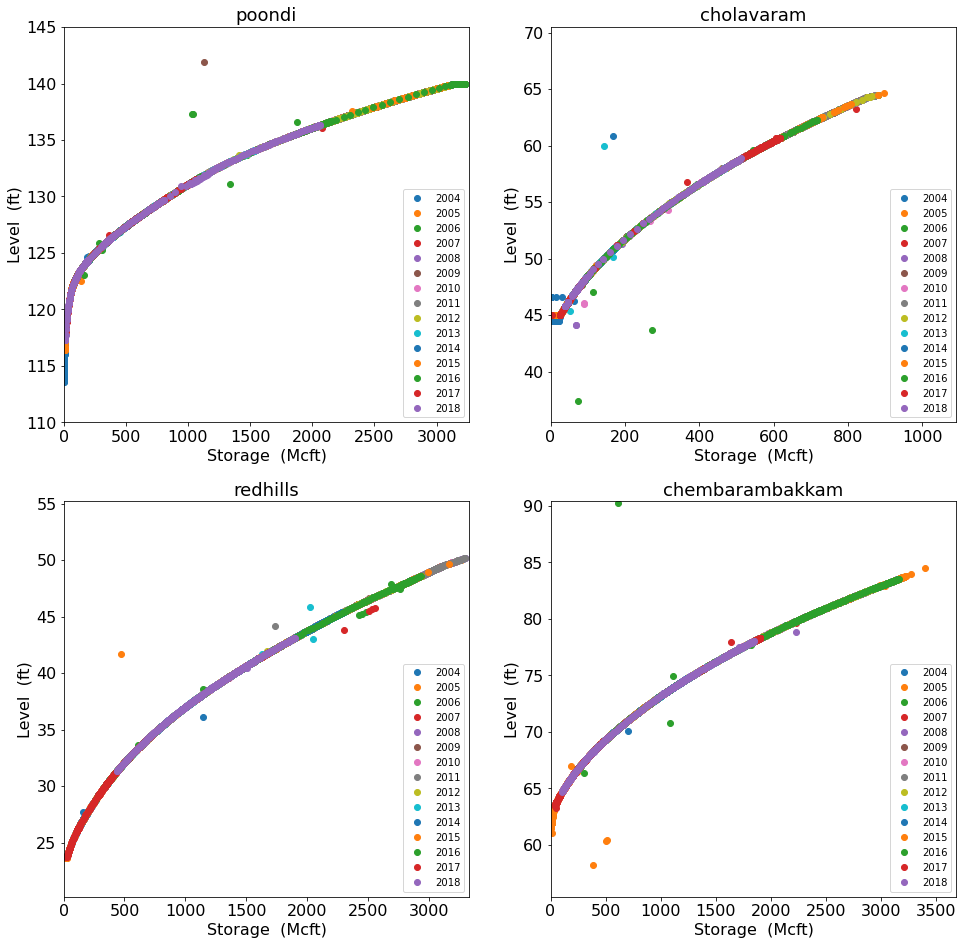

In [6]:
import matplotlib.pyplot as plt 

g, ((axa, axb), (axc, axd)) = plt.subplots(2,2, figsize=(16,16))

yloc = 'Level  (ft)'
xloc = 'Storage  (Mcft)'

plottingChennaiWaterData('poondi.csv', xloc, yloc, axa)

plottingChennaiWaterData('cholavaram.csv', xloc, yloc, axb)

plottingChennaiWaterData('redhills.csv', xloc, yloc, axc)

plottingChennaiWaterData('chembarambakkam.csv', xloc, yloc, axd)

### Plotting yearly median data for a reservoir

In [7]:
def plottingChennaiReservoirMedianYearlyData(filename, y1loc, y2loc, axobj):
    df_full = pd.read_csv(filename)
    yearlyMedianData = pd.DataFrame()
    #df_full = df_full.fillna('-')
    grpbyyr = df_full.groupby(df_full['date'].str.split('/', expand=True)[2])
    
    for group in grpbyyr.groups:
        year = group
        df = grpbyyr.get_group(group).dropna()
        df['Year'] = int(year)
        yearlyMedianData = yearlyMedianData.append(pd.DataFrame(df.median()).T)
        #print(yearlyMedianData)
        
    axobj.plot(yearlyMedianData['Year'], 
               yearlyMedianData[y1loc], 'o', c = 'b', label='level')
    axobj.set_xlim([yearlyMedianData['Year'].min()-1, 
                    yearlyMedianData['Year'].max()+1 ])
    axobj.set_xlabel('Year', fontsize=16)
    axobj.set_ylabel(y1loc, fontsize=16)
    axobj.legend(loc='upper left')
    
    plt.setp(axobj.get_xticklabels(), fontsize=16)
    plt.setp(axobj.get_yticklabels(), fontsize=16)
    
    axobjtwin = axobj.twinx()
    axobjtwin.plot(yearlyMedianData['Year'], 
                   yearlyMedianData[y2loc], 'd', c='r', label='volume')
    axobjtwin.set_ylabel(y2loc, fontsize=16)
    axobjtwin.legend(loc='upper right')
    
    plt.setp(axobjtwin.get_xticklabels(), fontsize=16)
    plt.setp(axobjtwin.get_yticklabels(), fontsize=16)
    axobj.set_title(filename.split('.')[0], fontsize=18)

### Example for plotting median data

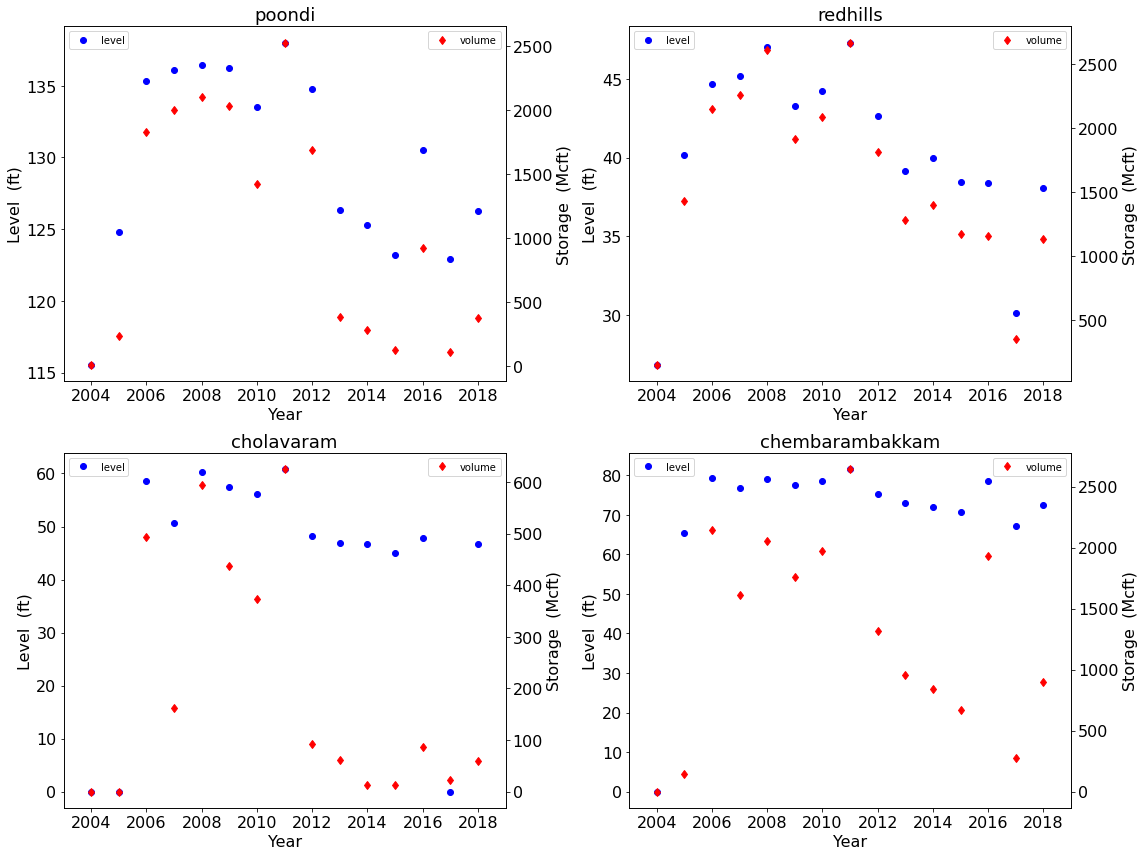

In [8]:
g, ((axa,axb),(axc,axd)) = plt.subplots(2,2, figsize=(16,12))
plottingChennaiReservoirMedianYearlyData('poondi.csv', 'Level  (ft)', 'Storage  (Mcft)', axa)
plottingChennaiReservoirMedianYearlyData('redhills.csv', 'Level  (ft)', 'Storage  (Mcft)', axb)
plottingChennaiReservoirMedianYearlyData('cholavaram.csv', 'Level  (ft)', 'Storage  (Mcft)', axc)
plottingChennaiReservoirMedianYearlyData('chembarambakkam.csv', 'Level  (ft)', 'Storage  (Mcft)', axd)
plt.tight_layout()

## ** Obtaining area of reservoir **

### ** Using scipy.curve_fit **
This is the more traditional method, especially for 1D curve fitting. However, you have to write the function which will be used to fit the
data, even if it is a simple polynomial. The coefficients have to be passed as individual parameters - a, b, c, ...

At least for polynomial functions, sklearn seems to be much easier as the order of the polynomial can be changed at will. We'll use sklearn in the next section.

In [309]:
from scipy.optimize import curve_fit
import numpy as np
from scipy import stats

resname = 'cholavaram'
resname = 'poondi'
resname = 'redhills'

# This is the data which I will use for fitting
df_full = pd.read_csv(resname+'.csv')

# xloc and yloc are column names of the a and y data
yloc = 'Level  (ft)'
xloc = 'Storage  (Mcft)'

df = df_full[[xloc, yloc]]

# Eliminating outliers from the data
df = df[((stats.zscore(df) < 1.8)).all(axis=1)]
df = df[((stats.zscore(df) > -0.8)).all(axis=1)]

# Defining functions for fitting
def cubicinln(x, a, b, c, d):
    return a + b*np.log(x) + c*(np.log(x))**2 + d*(np.log(x))**3

def area_cubicinln(x, b, c, d):
    return x*(b+ 2*c*np.log(x) + 3*d*(np.log(x))**2)**(-1)

def cubicinx(x, a, b, c, d):
    return a + b*x + c*x**2 + d*x**3

def area_cubicinx(x, b, c, d):
    return (b + 2.0*c*x + 3.0*d*x**2)**(-1.0)

def quadinx(x, a, b, c):
    return a + b*x + c*x**2 

def area_quadinx(x, b, c):
    return (b + 2.0*c*x)**(-1.0)


#popt, pcov = curve_fit(cubicinln, df[xloc], df[yloc])
#popt, pcov = curve_fit(cubicinx, df[xloc], df[yloc])

# Function that uses one of the above functions and plots the data
# as well as predictions, including area.
def vol_level_area_reservoir_chennai(filename, xloc, yloc, axa):
    df_full = pd.read_csv(filename)
    df = df_full[[xloc, yloc]]
    df = df.dropna()
    df = df[((stats.zscore(df) < 1.8)).all(axis=1)]
    df = df[((stats.zscore(df) > -0.8)).all(axis=1)]
    
    '''
    plottingChennaiWaterData(filename, xloc, yloc, axa)
    popt, pcov = curve_fit(cubicinx, df[xloc], df[yloc])
    area_res = area_cubicinx(np.sort(df[xloc]), popt[1], 
                             popt[2], popt[3])*0.0929
    axa.plot(np.sort(df[xloc]), cubicinx(np.sort(df[xloc]),
                                        popt[0], popt[1], popt[2], 
                                        popt[3]), 'r')    
    '''
    
        
    plottingChennaiWaterData(filename, xloc, yloc, axa)    
    popt, pcov = curve_fit(quadinx, df[xloc], df[yloc])
    area_res = area_quadinx(np.sort(df[xloc]), popt[1], popt[2])*0.0929
    axa.plot(np.sort(df[xloc]), quadinx(np.sort(df[xloc]),
                                        popt[0], popt[1], popt[2]), 'r')    

    
    axatwinx = axa.twinx()
    
    axatwinx.plot(np.sort(df[xloc]), area_res, 'b', label='Area')
    axatwinx.set_ylabel('Area (sq. km)', fontsize=16)
    plt.setp(axatwinx.get_yticklabels(), fontsize=16)
    
    return popt, area_res

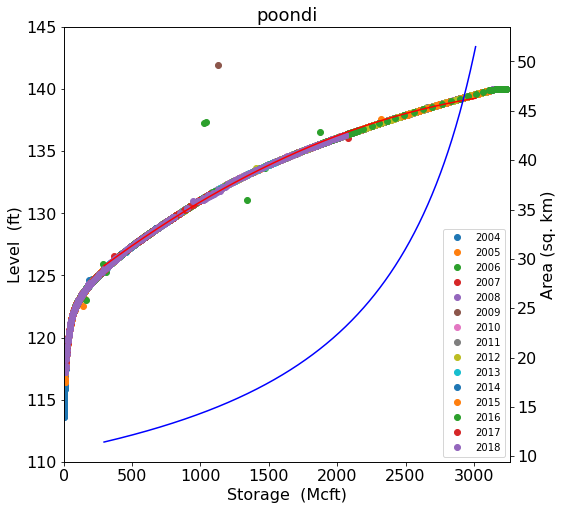

In [310]:
yloc = 'Level  (ft)'
xloc = 'Storage  (Mcft)'
f, axa = plt.subplots(1, figsize=(8,8))
fitparams, areafit = vol_level_area_reservoir_chennai('poondi.csv', xloc, yloc, axa)

### ** Using LinearRegression and PolynomialFeatures from sklearn **

LinearRegression (from sklearn.linear_model) is what is used for fitting the data. The function is supplied by PolynomialFeatures. You can set the degree. 

For the case of fitting level to volume, the polynomial methos leads to inconsistencies - the area depends strongly on the order of the polynomial. Between 2 and 3 and 4, there is plenty of difference in the computed area. I have used level as the dependent variable, and volume as the independent variable. Maybe it will be different if I exchange the dependent and independent variables - I have not tried it out yet.

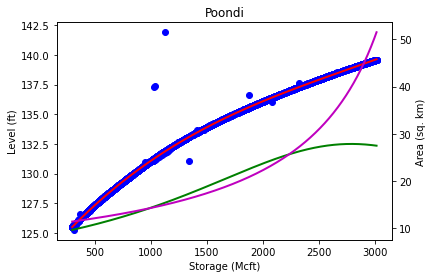

In [308]:
df_full = pd.read_csv('poondi.csv')
yloc = 'Level  (ft)'
xloc = 'Storage  (Mcft)'
df = df_full[[xloc, yloc]]
df = df.dropna()
df = df[((stats.zscore(df) < 1.8)).all(axis=1)]
df = df[((stats.zscore(df) > -0.8)).all(axis=1)]

X = df.iloc[:,0:1].values
y = df.iloc[:,1].values

# Fitting Polynomial Regression to the dataset 
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.linear_model import LinearRegression
  
poly = PolynomialFeatures(degree = 4) 
X_poly = poly.fit_transform(X) 

poly.fit(X_poly, y) 
lin2 = LinearRegression() 
lin2.fit(X_poly, y) 

# Visualising the Polynomial Regression results 
from numpy.polynomial.polynomial import polyval
deriv = np.array(lin2.coef_*np.arange(len(lin2.coef_)))[1:]

x_toplot = np.sort(df.iloc[:,0])
areainv = polyval(x_toplot, deriv)
area_pred = areainv**(-1.)*0.0929

X_toplot = x_toplot[:, np.newaxis]

plt.scatter(X, y, color = 'blue') 

plt.plot(X_toplot, lin2.predict(poly.fit_transform(X_toplot)), 
         color = 'red', lw=2) 
plt.title('Poondi') 
plt.xlabel('Storage (Mcft)') 
plt.ylabel('Level (ft)') 

ax = plt.gca()
axtwinx = ax.twinx()
axtwinx.plot(x_toplot, area_pred, label='area', c='g', lw=2)
axtwinx.set_ylabel('Area (sq. km)')
  
plt.show() 



### ** Using log(Volume) rather than Volume as independent variable **

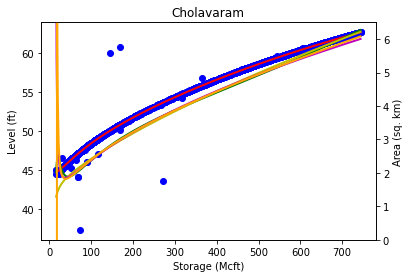

In [337]:
df_full = pd.read_csv('cholavaram.csv')
yloc = 'Level  (ft)'
xloc = 'Storage  (Mcft)'
df = df_full[[xloc, yloc]]
df = df.dropna()
df = df[((stats.zscore(df) < 1.8)).all(axis=1)]
df = df[((stats.zscore(df) > -0.8)).all(axis=1)]

X = np.log(df.iloc[:,0:1].values)
y = df.iloc[:,1].values

# Fitting Polynomial Regression to the dataset 
from sklearn.preprocessing import PolynomialFeatures 
  
poly = PolynomialFeatures(degree = 6) 
X_poly = poly.fit_transform(X) 

poly.fit(X_poly, y) 
lin2 = LinearRegression() 
lin2.fit(X_poly, y) 

# Visualising the Polynomial Regression results 
from numpy.polynomial.polynomial import polyval
deriv = np.array(lin2.coef_*np.arange(len(lin2.coef_)))[1:]

x_toplot = np.sort(np.log(df.iloc[:,0]))
areainv = polyval(x_toplot, deriv)
area_pred = np.exp(x_toplot)*areainv**(-1.)*0.0929

X_toplot = x_toplot[:, np.newaxis]

plt.scatter(np.exp(X), y, color = 'blue') 

plt.plot(np.exp(X_toplot), lin2.predict(poly.fit_transform(X_toplot)), 
         color = 'red', lw=2) 
plt.title('Cholavaram') 
plt.xlabel('Storage (Mcft)') 
plt.ylabel('Level (ft)') 

ax = plt.gca()
axtwinx = ax.twinx()

axtwinx.plot(np.exp(x_toplot), area_pred, label='area', c='g', lw=2)

axtwinx.plot(np.exp(x_toplot), area_pred_3, label='area 3', c='y', lw=2)
axtwinx.plot(np.exp(x_toplot), area_pred_4, label='area 4', c='m', lw=2)
axtwinx.plot(np.exp(x_toplot), area_pred_5, label='area 5', c='orange', lw=2)
axtwinx.set_ylim([0, 6.5])
#axtwinx.plot(np.exp(x_toplot), area_pred_6, label='area 6', c='b', lw=2)
axtwinx.set_ylabel('Area (sq. km)')

  
plt.show()

In [333]:
area_pred_6 = area_pred

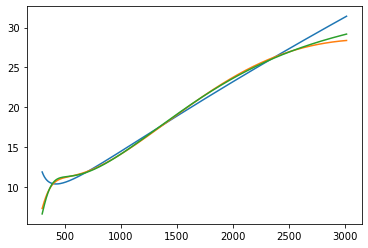

In [322]:
plt.plot(np.exp(x_toplot), area_pred_4, np.exp(x_toplot),area_pred_5, 
         np.exp(x_toplot),area_pred_6)

In [327]:
area_pred_3 = area_pred

In [329]:
area_pred_4 = area_pred